# Introduction

To make extended figure 1 more closely match the tables that Peng used I should use his matricies.

In [1]:
import scanpy as scanpy
import numpy
import pandas
import seaborn
import os
import sys
from matplotlib import pyplot

In [2]:
LONG_RNA_SEQ_DIR = os.path.expanduser('~diane/proj/long-rna-seq-condor')
if LONG_RNA_SEQ_DIR not in sys.path:
    sys.path.append(LONG_RNA_SEQ_DIR)

In [3]:
from woldrnaseq.models import load_gtf_cache
from woldrnaseq.gtfcache import protein_coding_gene_ids

In [4]:
%matplotlib inline

In [5]:
annotation = load_gtf_cache(os.path.expanduser('~diane/proj/genome/mm10-M4-male/mm10-M4-male.h5'))
protein_coding = protein_coding_gene_ids(annotation)

In [6]:
ls monocle

190714MouseLimb10Xraw.h5ad@  200120_C1.h5ad  cellbrowser_cluster.png
200120_10x.h5ad              200315_C1.h5ad  mouse/


In [7]:
colors = {
    '10x': '#377eb8',
    'C1': '#f3b125',
}
xlim = (0, 10000)

# Load approved 10x cell list

In [45]:
barcodes = pandas.read_csv('monocle/mouse/barcodes-to-cluster.csv', header=0, index_col=0)
print(barcodes.shape)
barcodes.head()

(90637, 1)


,orig.ident
limb12_13_0AAACCTGAGATCGATA_1,3
limb12_13_0AAACCTGAGATGAGAG_1,2
limb12_13_0AAACCTGAGCAGATCG_1,5
limb12_13_0AAACCTGAGCGATCCC_1,6
limb12_13_0AAACCTGAGTGTACCT_1,1


# 10x scanpy data

In [8]:
tenx_scanpy_data = scanpy.read(os.path.expanduser('monocle/200120_10x.h5ad'))

## figure out format of Peng's barcode strings

In [42]:
x = 'limb12_13_0AAACCTGAGATCGATA_1'

In [43]:
x.find("_", 7)

9

In [41]:
set([x[:x.find('_', 7)+2] for x in tenx_scanpy_data.obs_names])

{'limb12_13_0',
 'limb13_14_0',
 'limb1_13_5',
 'limb3_11_0',
 'limb4_12_0',
 'limb5_13_0',
 'limb6_15_0',
 'limb7_10_5',
 'limb8_15_0'}

## Back to analyzing 10x data

In [9]:
tenx_scanpy_data.shape

(90637, 43346)

In [10]:
tenx_scanpy_expression = numpy.sum(tenx_scanpy_data.X >= 1, axis=1)
tenx_scanpy_expression.shape

(90637,)

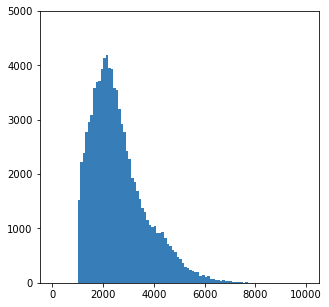

In [11]:
f = pyplot.figure(figsize=(5,5))
ax = f.add_subplot(1,1,1)
_ = ax.hist(tenx_scanpy_expression, bins=100, color=colors['10x'], range=xlim)
_ = ax.set_ylim(0, 5000)

# C1 Scanpy Data

In [12]:
c1_scanpy_data = scanpy.read(os.path.expanduser('monocle/200315_C1.h5ad'))
c1_scanpy_data.shape

(920, 28983)

In [13]:
c1_scanpy_expression = numpy.sum(c1_scanpy_data.X >= 1, axis=1)
c1_scanpy_expression.shape

(920,)

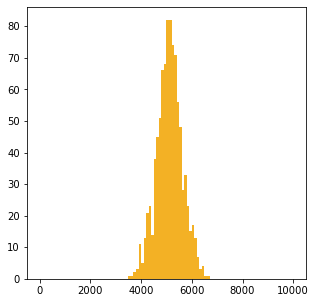

In [14]:
f = pyplot.figure(figsize=(5,5))
ax = f.add_subplot(1,1,1)
_ = ax.hist(c1_scanpy_expression, bins=100, color=colors['C1'], range=xlim)
#_ = ax.set_ylim(0, 50)

# C1 matrix

In [15]:
clusters = pandas.read_excel(
    os.path.expanduser('~diane/proj/C1_mouse_limb_combined/C1_single_cells_library_number_cell_type_annotation_Jan13_2019.ods'),
    'Sheet1',
    engine='odf',
)
clusters = clusters[['cell_ID', 'cell type cluster 920']]

In [16]:
genes_asof17 = pandas.read_csv(
    os.path.expanduser('~diane/proj/C1_mouse_limb_combined/C1_mouse_combined_asof_run17.tsv'),
    dtype={0: str},
    index_col=0,
    sep='\t')

In [17]:
c1_matrix = genes_asof17.loc[protein_coding][clusters.cell_ID]
c1_matrix.shape

(22032, 920)

In [18]:
c1_matrix_expression = c1_matrix[c1_matrix >= 1].count()
c1_matrix_expression.shape

(920,)

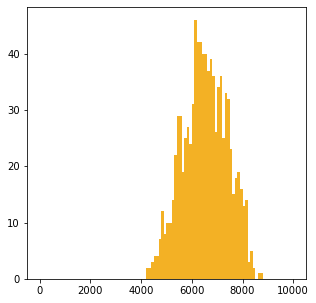

In [19]:
f = pyplot.figure(figsize=(5,5))
ax = f.add_subplot(1,1,1)
_ = ax.hist(c1_matrix_expression, bins=100, color=colors['C1'], range=xlim)
#_ = ax.set_ylim(0, 50)

# Compare gene filters

whats different between my and pengs annotation?

In [26]:
tenx_scanpy_data.var_names

Index(['RP23-271O17.1', 'Gm26206', 'Xkr4', 'RP23-317L18.1', 'RP23-317L18.4',
       'RP23-317L18.3', 'RP23-115I1.6', 'Gm1992', 'RP23-115I1.5',
       'RP23-115I1.2',
       ...
       'mt-Nd4', 'mt-Th', 'mt-Ts2', 'mt-Tl2', 'mt-Nd5', 'mt-Nd6', 'mt-Te',
       'mt-Cytb', 'mt-Tt', 'mt-Tp'],
      dtype='object', name='index', length=43346)

# Make combined matrix

In [22]:
combined = pandas.concat([
    pandas.DataFrame({
        'experiment type': ['10x'] * tenx_scanpy_expression.shape[0],
        'counts': tenx_scanpy_expression
    }),
    pandas.DataFrame({
        'experiment type': ['C1'] * c1_scanpy_expression.shape[0],
        'counts': c1_scanpy_expression
    }),
])
combined.shape

(91557, 2)

In [23]:
combined

,experiment type,counts
0,10x,3406
1,10x,2322
2,10x,2166
3,10x,3777
4,10x,2519
...,...,...
915,C1,4762
916,C1,5043
917,C1,4583
918,C1,4857


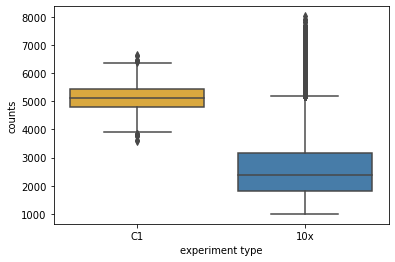

In [24]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
_ = seaborn.boxplot(x='experiment type', y='counts',
                    data=combined,
                    order=['C1', '10x'],
                    palette=colors,
                    color='black',
                    ax=ax
)

In [ ]:
combined.head()

In [ ]:
combined.to_csv('genes_detected_technology_scanpy.csv')